In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# suppress warnings
pd.options.mode.chained_assignment = None

Goals: 

* Replicate the cool analysis by David Robinson here http://varianceexplained.org/r/trump-tweets/ but in Python
* Mostly just for practice / exploring twitter data sets.

Pull in dataset - didn't want to both with Twitter authentication so I grabbed the R dataset "http://varianceexplained.org/files/trump_tweets_df.rda", converted it in R-Studio to a tsv file (using csv was a bad idea with twitter text) and pulled it into my local memory.

In [2]:
data = pd.read_csv("/Users/soohyunroh/Documents/Personal/trump_tweets/trump_tweets_df.tsv", sep="\t")

Get a feel for the dataset. What are the data types, what does it look like, any weirdness?

In [3]:
data.describe()

/Users/soohyunroh/.pyenv/versions/2.7.10/envs/jana-ipython/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,id,replyToUID,retweetCount,longitude,latitude
count,1.511000e+03,3.000000e+00,1511.000000,5.000000,5.000000
mean,7.305764e+17,1.468150e+08,6596.310390,-74.371430,40.702340
std,2.121922e+16,1.870245e+08,7222.911061,0.445840,0.065231
min,6.764942e+17,7.592510e+05,713.000000,-74.697119,40.654672
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,7.626699e+17,3.576069e+08,169526.000000,-73.880775,40.777377


In [4]:
# missing data in some of these columns is fine - won't worry about it now since i don't need those columns
# TOOD: figure out why they're missing? was it always missing or messed up the import?
data.isnull().sum()

text                0
favorited           8
favoriteCount       7
replyToSN        1515
created             7
truncated           7
replyToSID       1518
id                  8
replyToUID       1516
statusSource        8
screenName          8
retweetCount        8
isRetweet           8
retweeted           8
longitude        1514
latitude         1514
dtype: int64

In [5]:
data.dtypes

text              object
favorited         object
favoriteCount     object
replyToSN         object
created           object
truncated         object
replyToSID        object
id               float64
replyToUID       float64
statusSource      object
screenName        object
retweetCount     float64
isRetweet         object
retweeted         object
longitude        float64
latitude         float64
dtype: object

In [6]:
data.head()

,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude
0,My economic policy speech will be carried live...,False,9214,NaN,2016-08-08 15:20:44,False,NaN,7.626699e+17,NaN,"<a href=\http://twitter.com/download/android\""...",realDonaldTrump,3107.0,False,False,NaN,NaN
1,"Join me in Fayetteville, North Carolina tomorr...",False,6981,NaN,2016-08-08 13:28:20,False,NaN,7.626416e+17,NaN,"<a href=\http://twitter.com/download/iphone\"" ...",realDonaldTrump,2390.0,False,False,NaN,NaN
2,"#ICYMI: \Will Media Apologize to Trump?\"" http...",False,15724,NaN,2016-08-08 00:05:54,False,NaN,7.624397e+17,NaN,"<a href=\http://twitter.com/download/iphone\"" ...",realDonaldTrump,6691.0,False,False,NaN,NaN
3,"Michael Morell, the lightweight former Acting ...",False,19837,NaN,2016-08-07 23:09:08,False,NaN,7.624254e+17,NaN,"<a href=\http://twitter.com/download/android\""...",realDonaldTrump,6402.0,False,False,NaN,NaN
4,The media is going crazy. They totally distort...,False,34051,NaN,2016-08-07 21:31:46,False,NaN,7.624009e+17,NaN,"<a href=\http://twitter.com/download/android\""...",realDonaldTrump,11717.0,False,False,NaN,NaN


In [7]:
# filter to use only Android/iPhone dataset
# use na=False to indicate that NaNs should return false instead of NaN (otherwise can't index)
mobile_data = data[data.statusSource.str.contains("Android|iPhone", na=False)]

In [9]:
android_tweets = mobile_data[mobile_data.statusSource.str.contains("Android", na=False)]
iphone_tweets = mobile_data[mobile_data.statusSource.str.contains("iPhone", na=False)]

Look into Android/iPhone tweets descriptive

In [11]:
# create hour column (looks like you can only do that when the timestamp is an index in pandas)
mobile_data.index = pd.to_datetime(mobile_data['created'], box=True)
# TODO: how to set the timezone correctly to EST instead of UTC
mobile_data['hour_est'] = mobile_data.index.hour
mobile_data = mobile_data.reset_index(drop=True)

In [12]:
# create column to specify the source
mobile_data['source'] = 'Android'
mobile_data['source'][mobile_data.statusSource.str.contains("iPhone", na=False)] = 'iPhone'

In [13]:
# create column to specify if it has a picture
mobile_data['has_picture_or_link'] = 0
mobile_data['has_picture_or_link'][mobile_data.text.str.contains("t.co", na=False)] = 1

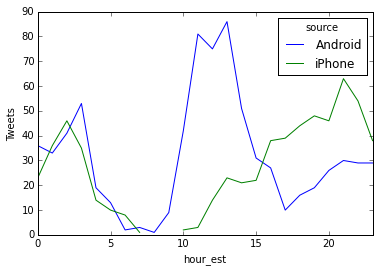

In [14]:
ax = pd.pivot_table(
    data=mobile_data,
    index='hour_est',
    columns='source',
    values="text",
    aggfunc="count").plot()
ax.set_ylabel("Tweets")

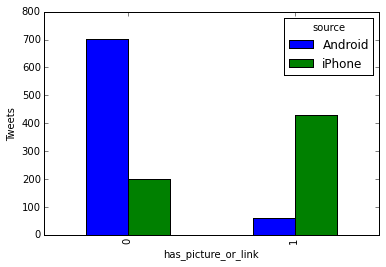

In [15]:
ax = pd.pivot_table(
    data=mobile_data,
    index='has_picture_or_link',
    columns='source',
    values="text",
    aggfunc="count").plot(kind="Bar")
ax.set_ylabel("Tweets")

Now to do some text analysis. Remove stopwords, punctuations, set to lowercase. Using the nltk package

In [16]:
from nltk.corpus import stopwords
import re

In [17]:
cached_stop_words = stopwords.words("english")

In [18]:
# I had stripped out stop words and punctuation and lowered but
# countvectorizer in sklearn takes care of all of these so I don't need this anymore

# strip out stop words
# mobile_data['text_scrubbed'] = mobile_data.text.map(lambda x: ' '.join(word for word in str(x).lower().split()
#                                                                       if word not in cached_stop_words))

# strip out punctuations
# mobile_data['text_scrubbed'] = mobile_data.text_scrubbed.map(lambda x: re.sub("[^A-Za-z0-9] ", " ", x))

In [19]:
# remove links
mobile_data['text_scrubbed'] = mobile_data.text.map(lambda x: re.sub("https://t.co/[A-Za-z\\d]+|&amp;", "", x))

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
# create the countvectorizer 
word_vectorizer = CountVectorizer(stop_words='english', lowercase=True, ngram_range=(1,1))
# fit/transform on the original text field
sparse_matrix = word_vectorizer.fit_transform(mobile_data['text_scrubbed'])
frequencies = sum(sparse_matrix).toarray()[0]
word_frequencies = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

In [21]:
# sort the words
word_frequencies = word_frequencies.sort_values(by='frequency', ascending=True)
word_frequencies.tail(15)

,frequency
new,72
make,73
cruz,79
just,85
america,87
people,103
clinton,106
makeamericagreatagain,111
crooked,124
realdonaldtrump,126


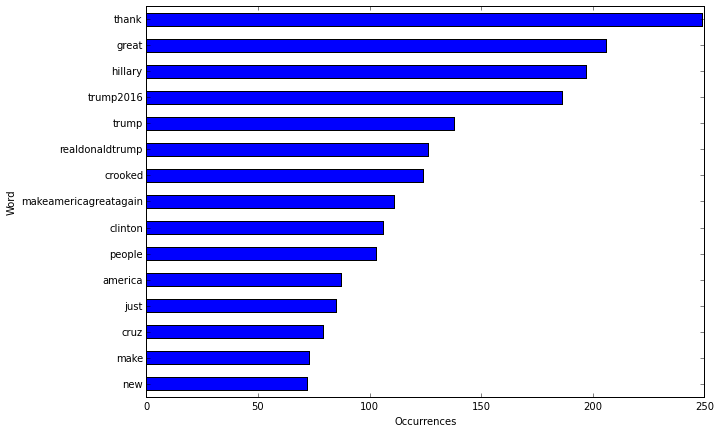

In [22]:
ax = word_frequencies.tail(15).plot(kind='barh', legend=False, figsize=(10, 7))
ax.set_xlabel('Occurrences')
ax.set_ylabel('Word')

Common Words by Source using Log Odds Ratio

In [23]:
android_sparse_matrix = word_vectorizer.fit_transform(mobile_data[mobile_data.source == 'Android']['text_scrubbed'])
android_frequencies = sum(android_sparse_matrix).toarray()[0]
android_word_frequencies = pd.DataFrame(android_frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
android_word_frequencies['source'] = 'Android'

In [24]:
iphone_sparse_matrix = word_vectorizer.fit_transform(mobile_data[mobile_data.source == 'iPhone']['text_scrubbed'])
iphone_frequencies = sum(iphone_sparse_matrix).toarray()[0]
iphone_word_frequencies = pd.DataFrame(iphone_frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
iphone_word_frequencies['source'] = 'iPhone'

In [25]:
word_freq_source = pd.concat([android_word_frequencies, iphone_word_frequencies])

In [27]:
word_freq_source_pv = pd.pivot_table(data=word_freq_source,
                                     index=word_freq_source.index,
                                     values='frequency',
                                     columns='source').fillna(0)

In [28]:
word_freq_source_pv['log_odds_ratio'] = np.log2(((word_freq_source_pv['Android'] + 1) / (word_freq_source_pv['Android'].sum() + 1))/
                                        ((word_freq_source_pv['iPhone'] + 1) / (word_freq_source_pv['iPhone'].sum() + 1)))

In [29]:
top_10_iphone = word_freq_source_pv.sort_values(by='log_odds_ratio', ascending=True).head(10)
top_10_android = word_freq_source_pv.sort_values(by='log_odds_ratio', ascending=False).head(10)
top_20 = pd.concat([top_10_iphone, top_10_android])

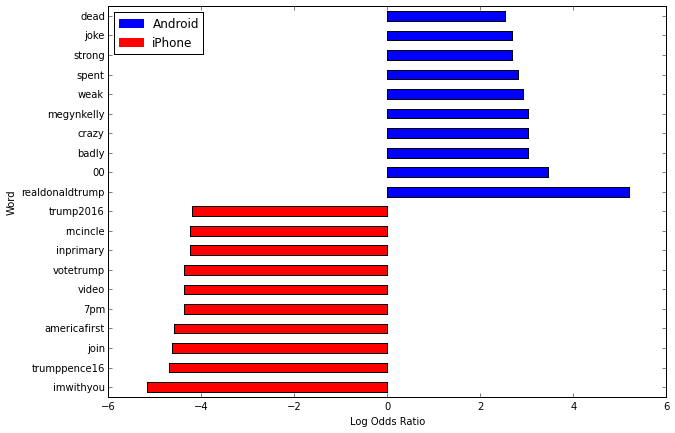

In [30]:
import matplotlib.patches as mpatches
ax = top_20['log_odds_ratio'].plot(kind='barh',
                                   color=['r']*10+['b']*10,
                                   figsize=(10,7))
ax.set_xlabel('Log Odds Ratio')
ax.set_ylabel('Word')
ax.legend([], ['Android', 'iPhone'])

Android = mpatches.Patch(color='b', label='Android')
iPhone = mpatches.Patch(color='r', label='iPhone')
ax.legend(handles=[Android, iPhone], loc=2)

Sentiment Analysis using NRC Emotion Lexicon

In [31]:
nrc = pd.read_csv("/Users/soohyunroh/Documents/Personal/trump_tweets/nrc_lexicon.txt", sep="\t")
nrc = nrc[nrc.flag == 1][['word', 'emotion']]

In [32]:
nrc.head()

,word,emotion
19,abacus,trust
23,abandon,fear
25,abandon,negative
27,abandon,sadness
30,abandoned,anger


In [33]:
word_freq_source = word_freq_source.reset_index()
word_emotion = pd.merge(word_freq_source, nrc, how='inner', left_on='index', right_on='word')
del word_emotion['index']

In [35]:
word_freq_source_pv.reset_index(inplace=True)

In [36]:
word_emotion_odds = pd.merge(word_emotion,
                             word_freq_source_pv[['index', 'log_odds_ratio']],
                             how='inner',
                             left_on='word',
                             right_on=word_freq_source_pv['index'])
del word_emotion_odds['index']

In [101]:
# keep rows where log odds ratio is positive and source = Android
# keep rows where log odds ratio is negative and source = iPhone
word_emotion_odds = word_emotion_odds[((word_emotion_odds.source == "Android") & (word_emotion_odds.log_odds_ratio > 0)) |
                                      ((word_emotion_odds.source == "iPhone") & (word_emotion_odds.log_odds_ratio < 0))]

In [37]:
# for each emotion, take the ten words, source with the highest magnitude log odds ratio
# first take the absolute value of the log odds ratio
word_emotion_odds['log_odds_ratio_abs'] = abs(word_emotion_odds['log_odds_ratio'])

In [102]:
top_words_index = [item[1] for item in word_emotion_odds.groupby('emotion')['log_odds_ratio_abs'].nlargest(10).index.values]

In [103]:
emotion_data = word_emotion_odds.loc[top_words_index]
emotion_data['positive'] = emotion_data['log_odds_ratio'] > 0

In [40]:
import matplotlib.pyplot as pyplot
import matplotlib
import seaborn

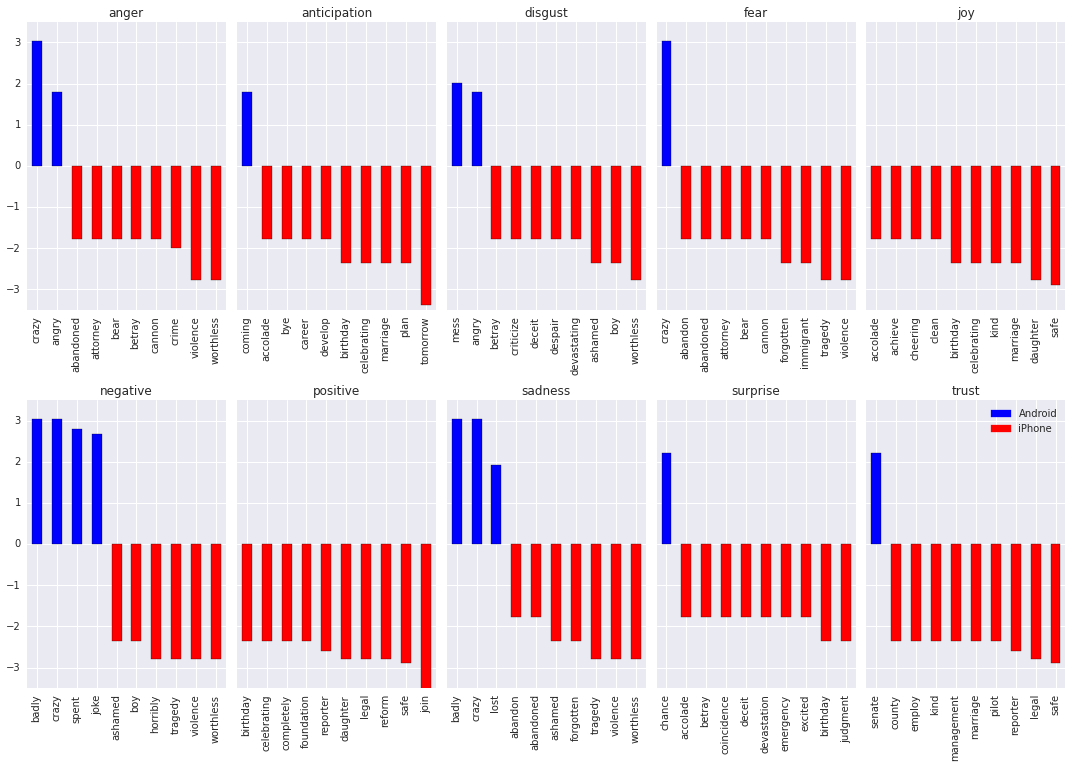

In [106]:
figure = pyplot.figure()

for k, emotion in enumerate(emotion_data.emotion.unique()):
    ax = figure.add_subplot(3, 5, k+1)
    data = emotion_data[emotion_data.emotion == emotion].sort_values(by="log_odds_ratio", ascending=False)
    ax = data.plot.bar(x="word", y="log_odds_ratio", ax=pyplot.gca(), sharey=ax, color=data.source.map({"iPhone": 'r', "Android": 'b'}))
    ax.get_legend().set_visible(False)
    ax.set_ylim([-3.5, 3.5])
    ax.set_title(emotion)
    ax.set_xlabel('')
    
figure.set_size_inches(15,15)
figure.tight_layout()

Android = mpatches.Patch(color='b', label='Android')
iPhone = mpatches.Patch(color='r', label='iPhone')
ax.legend(handles=[Android, iPhone])